In [1]:
from qiskit import *
import numpy as np
from qiskit.circuit.library import MCXGate
from qiskit.primitives import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
image = np.load('./data/images_test_100.npy')

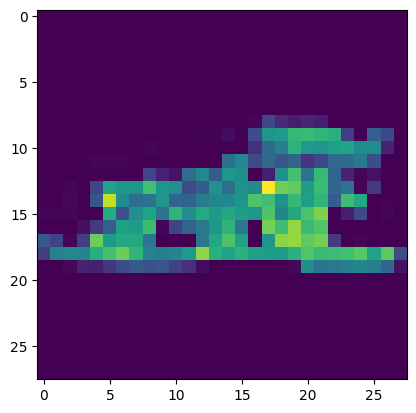

In [3]:
plt.imshow(image[1])

This data has 28*28 size.

So, to use my method, it is needed 5 qubits for X index and 5 qubits for Y index.

That is not ideal so I'm gonna cut off this image into 4*4

And intensity value is 0~255.

This makes need that 8 qubits.

That is also to large, so I'm gonna reduce this to 0~64

In [4]:
test_image = image[1]

quantum_input = test_image.reshape(7,7,4,4)
quantum_input = np.array(quantum_input/4,dtype=int)

In [5]:
def data_in_bit(inputs):
    res = []
    for i in inputs:
        temp = []
        for j in i:
            binary = format(j,'b').zfill(4)
            binary = reverse_str(binary)
            temp.append(binary)
        res.append(temp)
    return np.array(res)

In [6]:
def reverse_str(str_):
    res = ''
    for i in range(len(str_)):
        res = res + str_[-i-1]
    return res

In [9]:
X_index = QuantumRegister(2,name='X_layer')
Y_index = QuantumRegister(2,name='Y_layer')
coeffs = QuantumRegister(6,name='coeffs_layer')


qc_layers = []
for z in range(7):
    temp_layer = []
    for m in range(7):
        binary_inputs = data_in_bit(quantum_input[z][m])
        qc = QuantumCircuit(X_index,Y_index,coeffs)
        qc.draw('mpl')

        for i in range(2):
            qc.h(X_index[i])
        for i in range(2):
            qc.h(Y_index[i])

        for i in range(4):
            for j in range(4):
                X_idx = format(i,'b').zfill(2)
                Y_idx = format(j,'b').zfill(2)
                coeff = binary_inputs[i][j]
                gate = MCXGate(4,ctrl_state=X_idx+Y_idx)
                for index,k in enumerate(coeff):
                    if k == '1':
                        qc.append(gate,X_index[:]+Y_index[:]+[coeffs[index]])
                qc.barrier()
        qc.measure_all()
        temp_layer.append(qc)
    qc_layers.append(temp_layer)
            


/home/yslee/.local/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


In [26]:
all_result = []

for z in range(7):
    temp_result = []
    for m in range(7):
        
        sampler = Sampler()
        qc = qc_layers[z][m]
        result = sampler.run(qc).result().quasi_dists[0]
        binary_dict = {}

        for i in result.keys():
            binary_dict[format(i,'b').zfill(10)] = result[i]
            
        decoded_result = []
        
        for i in range(4):
            temp = []
            for j in range(4):
                X_idx = format(i,'b').zfill(2)
                Y_idx = format(j,'b').zfill(2)
                key = X_idx+Y_idx
                
                for k in binary_dict.keys():
                    if k[6:] == key:
                        temp.append(int(k[:6],2))
            decoded_result.append(temp)        
        decoded_result = np.array(decoded_result)*4
        temp_result.append(decoded_result)
    all_result.append(temp_result)
all_result = np.array(all_result)

final_res = all_result.reshape(28,28)



Input image


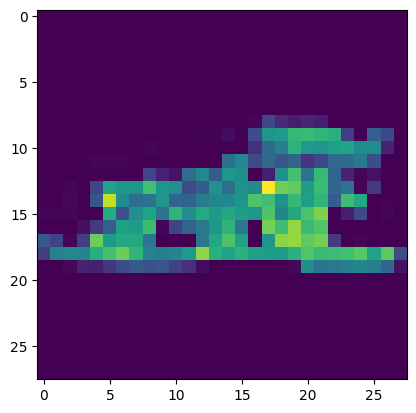

In [27]:
print('Input image')
plt.imshow(test_image)

Quantum image


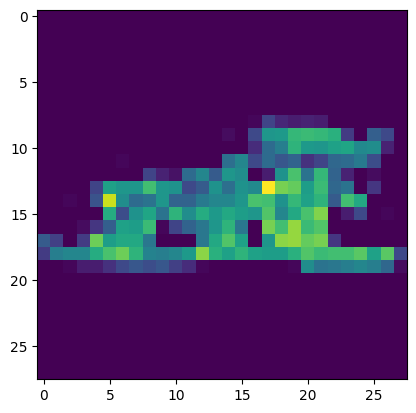

In [28]:
print('Quantum image')
plt.imshow(final_res)